In [1]:
#Imports
import keras
import keras.utils
from keras import utils as np_utils
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef


C:\Users\Hamish\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Function to load all the data
def load_all_data(filename):
    import numpy as np
    
    a = np.load(filename)
    d = (dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a))))

    return d

In [3]:
#Load the data
filename = ("alldata.npz")
X = load_all_data(filename)['data1arr_0']
y = load_all_data(filename)['data1arr_1']

IDs = load_all_data(filename)['data1arr_2']

In [4]:
#Split Data into Train_Test
from  sklearn.model_selection import GroupShuffleSplit
import numpy as np
test_size = 0.2
gss = GroupShuffleSplit(n_splits = 1, test_size = 0.2)

for train,test in gss.split(X, y, IDs):
    X_train = X[train]
    y_train = y[train]
    IDs_train = IDs[train]
    
    X_test = X[test]
    y_test = y[test]
    IDs_test = IDs[test]
    

fileoutname = 'train_test_data'
np.savez(fileoutname,X_train, y_train, X_test, y_test,IDs_train,IDs_test)

In [5]:
#Split Data in Train2_Dev
gss = GroupShuffleSplit(1, test_size = 0.2)

for train,test in gss.split(X, y, IDs):
    X_train2 = X[train]
    y_train2 = y[train]
    IDs_train = IDs[train]
    
    X_dev = X[test]
    y_dev = y[test]
    IDs_test = IDs[test]

fileoutname = 'train_dev_data'
np.savez(fileoutname,X_train, y_train, X_test, y_test, IDs_train, IDs_test)

In [6]:
#Add dimensions for X in CNN and Convert y to Categorical
X_train2 = np.expand_dims(X_train2,axis=4)
y_train2 = keras.utils.to_categorical(y_train2,num_classes=2)
X_dev = np.expand_dims(X_dev,axis=4)
y_dev = keras.utils.to_categorical(y_dev,num_classes=2)

C:\Users\Hamish\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  
C:\Users\Hamish\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


In [7]:
#Build the CNN
def  simpleCNN(self, units = 10):
    
    import keras
    from keras.layers import Dense
    from keras.layers import Conv2D, MaxPooling2D
    from keras.layers import Flatten, Dropout
    from keras.models import Model, Input
    
    inp =  Input(shape = self.shape[1:], name='inp')
    #layer 1
    x = Conv2D(units, kernel_size=(1,1), strides = (1,1), activation='relu', data_format='channels_last')(inp)  
    #Dropout Layer
    x = Dropout(rate = 0.2)(x) 
    #layer 2
    x = Conv2D(units, kernel_size=(2,2), strides = (1,1), activation='relu', data_format='channels_last')(x) 
    # Dropout Layer
    x = Dropout(rate = 0.2)(x) 
    #layer 3
    x = Conv2D(units, kernel_size=(2,2), strides = (1,1), activation='relu', data_format='channels_last')(x) 
    #layer 4
    x = Dropout(rate = 0.2)(x) 
    #layer 5
    x = Conv2D(units, kernel_size=(2,2), strides = (1,1), activation='relu', data_format='channels_last')(x) 
    #layer 6
    x = Dropout(rate = 0.2)(x) 
    #layer 7
    x = MaxPooling2D(pool_size=(2,2), strides = (2,2), padding='valid', data_format='channels_last')(x)  
    #layer 8
    x = Flatten()(x)
    #layer 9
    out = Dense(2, activation='softmax',name='out')(x)
    
    model = Model(inputs = inp, outputs = out)
    
    return model

In [8]:
#Assign CNN to model
model = simpleCNN(X_train2)

In [9]:
#Define custom metric - Matthews Correlation
y_pred = model.predict(X_train2)

import keras.backend as K

def matthews_correlation(y_train2, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    
    y_pos = K.round(K.clip(y_train2, 0, 1))
    y_neg = 1 - y_pos
    
    
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    return numerator / (denominator + K.epsilon())


In [10]:
#Fit Data to Model
from keras.optimizers import Adamax
from keras import metrics
adamax = Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0); #3e-4; 2e-3 is a default.
model.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['acc',matthews_correlation])
history = model.fit(X_train2, y_train2, epochs=150
                    , batch_size=32, verbose = 1, validation_data = (X_dev, y_dev))

Train on 9186 samples, validate on 2273 samples
Epoch 1/150
9186/9186 [==============================] - 46s 5ms/step - loss: 2.1355 - acc: 0.6829 - matthews_correlation: 0.3658 - val_loss: 1.4951 - val_acc: 0.7440 - val_matthews_correlation: 0.4879
Epoch 2/150
9186/9186 [==============================] - 47s 5ms/step - loss: 1.5655 - acc: 0.7553 - matthews_correlation: 0.5106 - val_loss: 1.4632 - val_acc: 0.7444 - val_matthews_correlation: 0.4888
Epoch 3/150
9186/9186 [==============================] - 47s 5ms/step - loss: 1.4794 - acc: 0.7567 - matthews_correlation: 0.5134 - val_loss: 1.4904 - val_acc: 0.7466 - val_matthews_correlation: 0.4932
Epoch 4/150
9186/9186 [==============================] - 48s 5ms/step - loss: 1.3227 - acc: 0.7717 - matthews_correlation: 0.5434 - val_loss: 1.4434 - val_acc: 0.7523 - val_matthews_correlation: 0.5046
Epoch 5/150
9186/9186 [==============================] - 49s 5ms/step - loss: 1.2922 - acc: 0.7708 - matthews_correlation: 0.5417 - val_loss: 1.

9186/9186 [==============================] - 46s 5ms/step - loss: 0.7724 - acc: 0.8350 - matthews_correlation: 0.6699 - val_loss: 0.9748 - val_acc: 0.7972 - val_matthews_correlation: 0.5944
Epoch 42/150
9186/9186 [==============================] - 46s 5ms/step - loss: 0.8281 - acc: 0.8285 - matthews_correlation: 0.6571 - val_loss: 1.0791 - val_acc: 0.7928 - val_matthews_correlation: 0.5856
Epoch 43/150
9186/9186 [==============================] - 45s 5ms/step - loss: 0.7411 - acc: 0.8373 - matthews_correlation: 0.6745 - val_loss: 1.0506 - val_acc: 0.8051 - val_matthews_correlation: 0.6102
Epoch 44/150
9186/9186 [==============================] - 45s 5ms/step - loss: 0.8017 - acc: 0.8342 - matthews_correlation: 0.6684 - val_loss: 0.9958 - val_acc: 0.8113 - val_matthews_correlation: 0.6225
Epoch 45/150
9186/9186 [==============================] - 46s 5ms/step - loss: 0.7813 - acc: 0.8326 - matthews_correlation: 0.6651 - val_loss: 1.0884 - val_acc: 0.8011 - val_matthews_correlation: 0.602

9186/9186 [==============================] - 47s 5ms/step - loss: 0.6238 - acc: 0.8553 - matthews_correlation: 0.7106 - val_loss: 0.8905 - val_acc: 0.8201 - val_matthews_correlation: 0.6401
Epoch 82/150
9186/9186 [==============================] - 48s 5ms/step - loss: 0.6197 - acc: 0.8546 - matthews_correlation: 0.7091 - val_loss: 0.9077 - val_acc: 0.8236 - val_matthews_correlation: 0.6472
Epoch 83/150
9186/9186 [==============================] - 48s 5ms/step - loss: 0.5733 - acc: 0.8607 - matthews_correlation: 0.7213 - val_loss: 0.8807 - val_acc: 0.8218 - val_matthews_correlation: 0.6436
Epoch 84/150
9186/9186 [==============================] - 48s 5ms/step - loss: 0.5883 - acc: 0.8546 - matthews_correlation: 0.7091 - val_loss: 0.8002 - val_acc: 0.8333 - val_matthews_correlation: 0.6665
Epoch 85/150
9186/9186 [==============================] - 48s 5ms/step - loss: 0.5863 - acc: 0.8527 - matthews_correlation: 0.7054 - val_loss: 0.8445 - val_acc: 0.8297 - val_matthews_correlation: 0.659

9186/9186 [==============================] - 47s 5ms/step - loss: 0.4898 - acc: 0.8764 - matthews_correlation: 0.7529 - val_loss: 0.8654 - val_acc: 0.8311 - val_matthews_correlation: 0.6621
Epoch 122/150
9186/9186 [==============================] - 47s 5ms/step - loss: 0.4733 - acc: 0.8791 - matthews_correlation: 0.7581 - val_loss: 0.9213 - val_acc: 0.8381 - val_matthews_correlation: 0.6762
Epoch 123/150
9186/9186 [==============================] - 48s 5ms/step - loss: 0.5386 - acc: 0.8810 - matthews_correlation: 0.7620 - val_loss: 0.9459 - val_acc: 0.8377 - val_matthews_correlation: 0.6753
Epoch 124/150
9186/9186 [==============================] - 48s 5ms/step - loss: 0.4993 - acc: 0.8752 - matthews_correlation: 0.7505 - val_loss: 0.8381 - val_acc: 0.8355 - val_matthews_correlation: 0.6709
Epoch 125/150
9186/9186 [==============================] - 50s 5ms/step - loss: 0.5077 - acc: 0.8804 - matthews_correlation: 0.7607 - val_loss: 0.8631 - val_acc: 0.8350 - val_matthews_correlation: 0

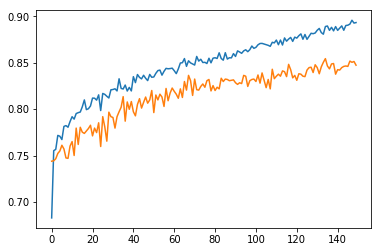

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

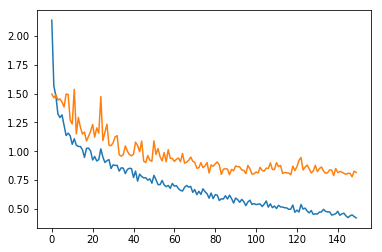

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

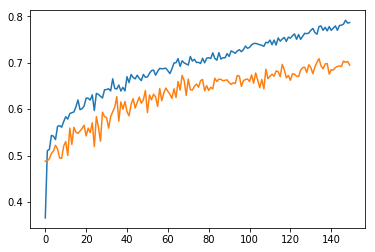

In [13]:
plt.plot(history.history['matthews_correlation'])
plt.plot(history.history['val_matthews_correlation'])

In [14]:
y_pred = model.predict(X_dev)

In [15]:
import sklearn.metrics as sklm
cm = sklm.confusion_matrix(y_dev.argmax(axis=1),y_pred.argmax(axis=1))
cm

array([[ 464,  259],
       [  88, 1462]], dtype=int64)

In [16]:
a_s = sklm.accuracy_score(y_dev.argmax(axis=1),y_pred.argmax(axis=1))
a_s

0.8473383194016718

In [17]:
c_r = sklm.classification_report(y_dev.argmax(axis=1),y_pred.argmax(axis=1))
print(c_r)

              precision    recall  f1-score   support

           0       0.84      0.64      0.73       723
           1       0.85      0.94      0.89      1550

   micro avg       0.85      0.85      0.85      2273
   macro avg       0.85      0.79      0.81      2273
weighted avg       0.85      0.85      0.84      2273



In [18]:
#Bring in Test Data for Analysis

#Convert Test Set Data
X_train = np.expand_dims(X_train,axis=4)
y_train = keras.utils.to_categorical(y_train,num_classes=2)

C:\Users\Hamish\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


In [19]:
y_pred_train = model.predict(X_train)

In [20]:
import sklearn.metrics as sklm
cm2 = sklm.confusion_matrix(y_train.argmax(axis=1),y_pred_train.argmax(axis=1))
cm2

array([[1976, 1029],
       [ 144, 6312]], dtype=int64)

In [21]:
a_s2 = sklm.accuracy_score(y_train.argmax(axis=1),y_pred_train.argmax(axis=1))
a_s2

0.8760173343198393

In [22]:
c_r2 = sklm.classification_report(y_train.argmax(axis=1),y_pred_train.argmax(axis=1))
print(c_r2)

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      3005
           1       0.86      0.98      0.91      6456

   micro avg       0.88      0.88      0.88      9461
   macro avg       0.90      0.82      0.84      9461
weighted avg       0.88      0.88      0.87      9461

